In [1]:
import json
import networkx as nx
from networkx.algorithms import bipartite
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain
import tqdm.notebook as tqdm
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
outpath = "./results"

In [3]:
with open(os.path.join(outpath, "spaces.json")) as f:
    spaces = json.load(f)

In [4]:
G = nx.DiGraph()
for space in spaces:
    G.add_node(space['id'], node_type="space", data=space)
    proposals = os.listdir(os.path.join(outpath, 'spaces', space['id']))
    for proposal in proposals:
        with open(os.path.join(outpath, 'spaces', space['id'], proposal)) as f:
            data = json.load(f)
            votes = data["votes_data"]
            del data['votes_data'] # That's to save space because we are abstracting it away as nodes, not need to have a huge network for no reason
            G.add_node(data['id'], node_type="proposal", data=data)
            G.add_edge(data['id'], space['id'])
            for vote in votes:
                G.add_node(vote['voter'], node_type="user")
                G.add_edge(vote['voter'], data['id'], data=vote)
                G.add_edge(vote['voter'], space['id'])                

# Manipulating the network

In [5]:
# This is how we can get all the different spaces proopsals and users in the network
spaces = [n for n in G.nodes() if G.nodes[n]['node_type'] == "space"]
proposals = [n for n in G.nodes() if G.nodes[n]['node_type'] == "proposal"]
voters = [n for n in G.nodes() if G.nodes[n]['node_type'] == "user"]

In [6]:
# Here we can sort the list of spaces by the number of proposals, to do this we use the degree of the node
degs = nx.degree(G)
space_deg = [(space, degs[space]) for space in spaces]
space_deg = sorted(space_deg, key=lambda k: k[1], reverse=True)

In [7]:
len([v for v in voters if degs[v] <= 2]) / len(voters)

0.5786415693819879

In [8]:
# Now we can also get all the proposals for a space as well as the users for a space and a proposal
space = space_deg[35][0]
space_childrens = list(nx.ancestors(G, space))
space_proposals = [n for n in space_childrens if G.nodes[n]['node_type'] == "proposal"]
space_voters = [n for n in space_childrens if G.nodes[n]['node_type'] == "user"]
proposal_voters = nx.ancestors(G, space_proposals[0])
print("Space:", space, "Proposals:", len(space_proposals), "Voters:", len(space_voters))

Space: snapshot.dcl.eth Proposals: 398 Voters: 1429


# Projecting the Space network connected by voters

In [10]:
len(voters)

315997

# Projecting the voter network of a DAO

In [11]:
subG = nx.subgraph(G, space_voters+space_proposals)

In [12]:
usersG = nx.algorithms.bipartite.projected_graph(nx.Graph(subG), space_voters)

In [13]:
users_deg = [(user, degs[user]) for user in usersG]

In [14]:
users_filter = [el[0] for el in users_deg if el[1] > 2]

In [15]:
print("Participated only once:", len(usersG) - len(users_filter), "remaining after filter:", len(users_filter))

Participated only once: 332 remaining after filter: 1097


In [16]:
usersG = nx.subgraph(usersG, users_filter)

In [17]:
%time partition = community_louvain.best_partition(usersG)

CPU times: user 1.38 s, sys: 6.93 ms, total: 1.38 s
Wall time: 1.38 s


In [18]:
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

In [19]:
pos=nx.spring_layout(usersG, k=1)

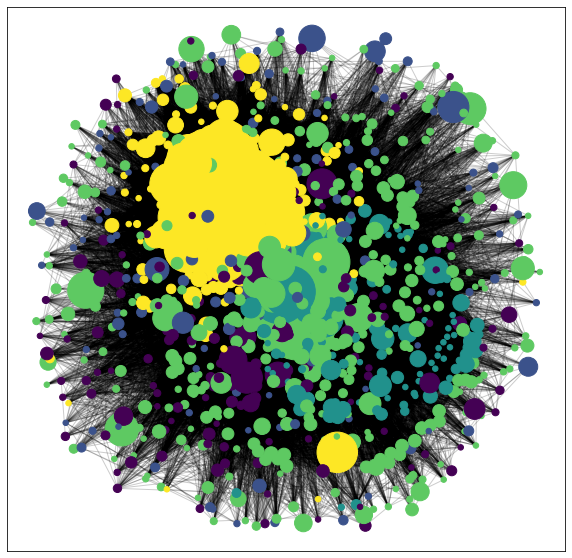

In [20]:
size = [degs[user]*10 for user in usersG]
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(usersG, pos=pos,  node_size=size, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(usersG, pos=pos,  node_size=size, alpha=0.2)

# Question: What is the proportion of voters with "degree=1" (aka vote only once) per space

In [27]:
sns.set()

In [28]:
filterout = []
for space in spaces:
    if degs[space] == 1:
        filterout.append(space)

In [29]:
degs = nx.degree(G)
result = []
for space in tqdm.tqdm(spaces):
    space_childrens = list(nx.ancestors(G, space))
    space_voters = [n for n in space_childrens if G.nodes[n]['node_type'] == "user"]
    space_proposals = [n for n in space_childrens if G.nodes[n]['node_type'] == "proposal"]
    if len(space_voters) > 0:
        onlyonce = [user for user in space_voters if degs[user] == 2]
        result.append([space, len(onlyonce), len(space_voters), 1 - (len(space_voters) - len(onlyonce))/len(space_voters), len(space_proposals)])
result = pd.DataFrame(result, columns=["Space", "Single voters", "Voters", "Proportion", "Proposals count"])

  0%|          | 0/3490 [00:00<?, ?it/s]

/home/xqua/anaconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

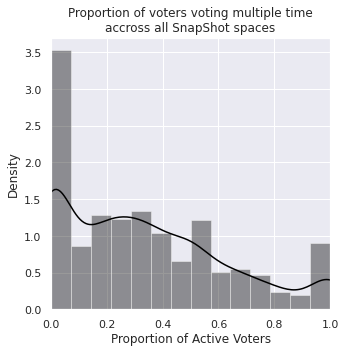

In [30]:
plt.figure(figsize=(5,5))
sns.distplot(result['Proportion'], color="black")
plt.title("Proportion of voters voting multiple time\naccross all SnapShot spaces")
plt.xlabel("Proportion of Active Voters")
plt.xlim(0,1)

Text(0.5, 0, 'Proportion of Active Voters')

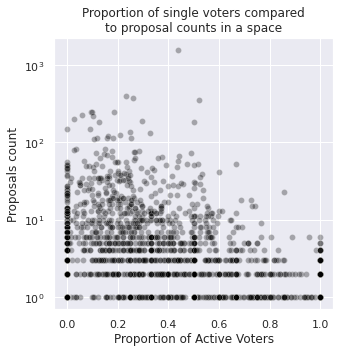

In [44]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=result, x="Proportion", y="Proposals count", color="black", alpha=0.3)
plt.yscale('log')
plt.title("Proportion of single voters compared\nto proposal counts in a space")
plt.xlabel("Proportion of Active Voters")

In [45]:
result['ProposalNormed'] = result['Proposals count']/result['Voters']

Text(0, 0.5, 'Space Proposal/Members')

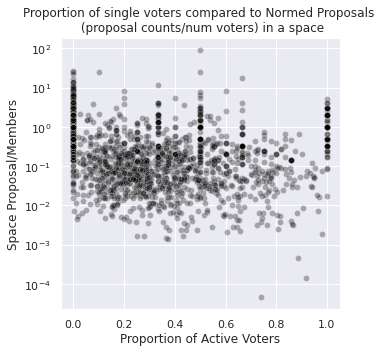

In [46]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=result, x="Proportion", y="ProposalNormed", color="black", alpha=0.3)
plt.yscale('log')
plt.title("Proportion of single voters compared to Normed Proposals \n (proposal counts/num voters) in a space")
plt.xlabel("Proportion of Active Voters")
plt.ylabel("Space Proposal/Members")


## With unique proposal spaces filtered out

In [31]:
degs = nx.degree(G)
result = []
for space in tqdm.tqdm([s for s in spaces if s not in filterout]):
    space_childrens = list(nx.ancestors(G, space))
    space_voters = [n for n in space_childrens if G.nodes[n]['node_type'] == "user"]
    space_proposals = [n for n in space_childrens if G.nodes[n]['node_type'] == "proposal"]
    if len(space_voters) > 0:
        onlyonce = [user for user in space_voters if degs[user] == 2]
        result.append([space, len(onlyonce), len(space_voters), 1 - (len(space_voters) - len(onlyonce))/len(space_voters), len(space_proposals)])
result = pd.DataFrame(result, columns=["Space", "Single voters", "Voters", "Proportion", "Proposals count"])

  0%|          | 0/3268 [00:00<?, ?it/s]

/home/xqua/anaconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1.0)

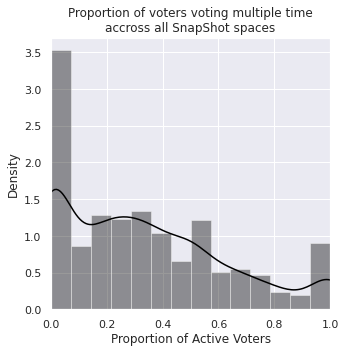

In [32]:
plt.figure(figsize=(5,5))
sns.distplot(result['Proportion'], color="black")
plt.title("Proportion of voters voting multiple time\naccross all SnapShot spaces")
plt.xlabel("Proportion of Active Voters")
plt.xlim(0,1)

Text(0.5, 0, 'Proportion of Active Voters')

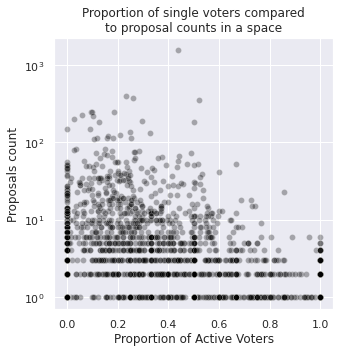

In [33]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=result, x="Proportion", y="Proposals count", color="black", alpha=0.3)
plt.yscale('log')
plt.title("Proportion of single voters compared\nto proposal counts in a space")
plt.xlabel("Proportion of Active Voters")

In [34]:
result['ProposalNormed'] = result['Proposals count']/result['Voters']

Text(0, 0.5, 'Space Proposal/Members')

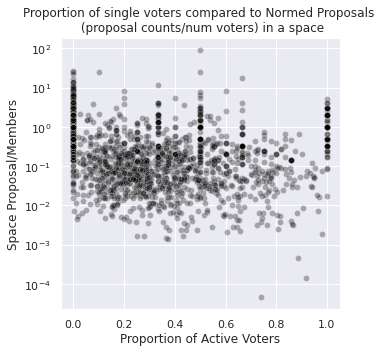

In [35]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=result, x="Proportion", y="ProposalNormed", color="black", alpha=0.3)
plt.yscale('log')
plt.title("Proportion of single voters compared to Normed Proposals \n (proposal counts/num voters) in a space")
plt.xlabel("Proportion of Active Voters")
plt.ylabel("Space Proposal/Members")


# Some more "classical" datascience use of the data

In [ ]:
space_vote_dist = {}
space_voters = {}
for space in spaces:
    proposals = os.listdir(os.path.join(outpath, 'spaces', space['id']))
    for proposal in proposals:
        with open(os.path.join(outpath, 'spaces', space['id'], proposal)) as f:
            data = json.load(f)
            votes = data["votes_data"]
            del data['votes_data']
            for vote in votes:
                if vote['space']['id'] not in space_vote_dist:
                    space_vote_dist[vote['space']['id']] = 0
                space_vote_dist[vote['space']['id']] += 1
                if vote['space']['id'] not in space_voters:
                    space_voters[vote['space']['id']] = {}
                if not vote['voter'] in space_voters[vote['space']['id']]:
                    space_voters[vote['space']['id']][vote['voter']] = True

In [6]:
data = []
data2 = []
for k in space_vote_dist:
    data.append((k, space_vote_dist[k]))
    data2.append((k, len(space_voters[k])))

In [7]:
tmp = sorted(data, key=lambda k: k[1], reverse=True)
X, Y = [], []
for el in tmp:
    X.append(el[0])
    Y.append(el[1])

Text(0.5, 1.0, '(Inequal) number of votes per space')

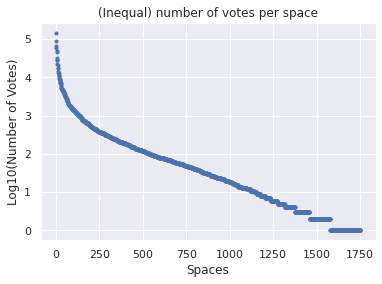

In [8]:
plt.plot(range(len(X)), np.log10(Y), '.')
plt.ylabel('Log10(Number of Votes)')
plt.xlabel('Spaces')
plt.title("(Inequal) number of votes per space")

In [9]:
tmp = sorted(data2, key=lambda k: k[1], reverse=True)
X, Y = [], []
for el in tmp:
    X.append(el[0])
    Y.append(el[1])

Text(0.5, 1.0, '(Inequal) number of voters per space')

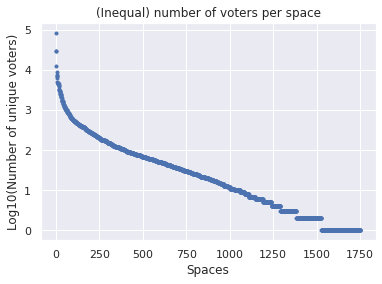

In [10]:
plt.plot(range(len(X)), np.log10(Y), '.')
plt.ylabel('Log10(Number of unique voters)')
plt.xlabel('Spaces')
plt.title("(Inequal) number of voters per space")